In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
%matplotlib inline

In [3]:
tf.__version__

'1.2.1'

In [4]:
#Convolutional layer 1
#5 x 5 filter 
filter_size = 5
#6 different (5x5) parameter sets
num_filters = 6
#Fully-connected layer
fc_size = 128

## load data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [32]:
# The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. 
#The index of this one element is the class-number, that is, the digit shown in the associated image. 
#We also need the class-numbers as integers for the test-set, so we calculate it now.
print("The test data looks like:\n{}\n".format(data.test.labels))
data.test.cls = np.argmax(data.test.labels, axis = 1)
print("Test data after converting one-hot to class:\n{}\n".format(data.test.cls))

print("Image dimension is {}\n".format(data.test.images[0].shape))
print("one test image looks like:\n{}.\n".format(data.test.images[0]))

The test data looks like:
[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Test data after converting one-hot to class:
[7 2 1 ..., 4 5 6]

Image dimension is (784,)

one test image looks like:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          

In [18]:
#Data Dimension
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [19]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plot.
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
        

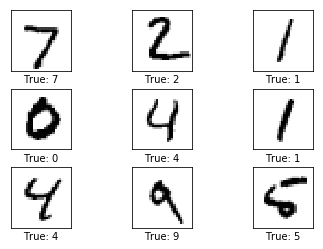

In [20]:
#plot the data
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true = cls_true)

### 1. Placeholder variables used for inputting data to the graph.

### 2. Variables that are going to be optimized so as to make the convolutional network perform better.
### 3.The mathematical formulas for the convolutional network.
### 4. A cost measure that can be used to guide the optimization of the variables.
### 5. An optimization method which updates the variables.

In [35]:
#Functions for creating new TensorFlow variables in the given shape and initializing them with random values. 
#Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.
def new_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))

### Helper function to create a new convolutional layer
It is assumed that the input is a 4-dim tensor with the following dimensions:
1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.
The output is another 4-dim tensor with the following dimensions:
1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [ ]:
def new_conv_layer(input, num_input_channel, filter_size, num_filters, use_pooling = True):
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channel, num_filters]
    